Multi System Kynetic Transitions


This notebook demonstrates how to create complex approaches for fitting non-standard time-resolved dimensions. We strongly recommend that you first review Example 1, then Example 5, and then begin working with this notebook.


We'll explore:

1) The general logic of matrix generators
2) The ways of rewriting the population dynamics for our particular case 
3) Internal logic of the context

\
\
\
\
\
\
For any questions, please contact Arkady Samsonenko via: \
Telegram: @Arkady_Samsonenko \
Email: a.samsonenko.tomo.nsc.ru

In [1]:
# Import necessary libraries
import typing as tp
import sys
import os
import math
from importlib import reload

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import optuna
import nevergrad as ng

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import Mars library components
import mars
from mars import spin_system, spectra_manager, mesher, constants
from mars import utils
from mars import population

Some stuff might fail: issue in joblib


In [2]:
dtype = torch.float64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 1. Problem Statement

We consider the following task: modeling transitions between two systems between which population transfer occurs. A schematic illustration is shown in the figure below.

There are two distinct spin systems:
- **System 1** (the *reservoir*)  
- **System 2** (the *probe*)

Each system has its own internal relaxation behavior. Populations transfer from the reservoir to the probe according to a defined kinetic matrix. We assume that only the probe system contributes to the observable signal, because the reservoir produces a broad, unresolvable signal that cannot be detected.

<img src="multi_systems_transitions.png" alt="Drawing" style="width: 800px;"/>
Illustration of two spin systems: reservoir and probe, with different relaxation parameters

\
\
To model this scenario, we break the relaxation process into the following steps:

1. **Formation of the reservoir**: The reservoir is populated from an initial (low-energy) state. The initial population is formed
2. **Transfer to the probe**: Populations move from the reservoir to the probe with certain *transfer probabilities* (`chem_probs`).
3. **Loss from the probe**: The probe system loses population with specified *output probabilities* (`out_probs`).
4. **Internal relaxation**: Both systems undergo their own internal spin relaxation, which can be described using standard MarS relaxation contexts.
5. **Signal formation**: The observed signal is proportional to the population difference between resonant states of the probe system. We model this by tracking the time evolution of the probabilities.

In this framework, the reservoir acts as a hidden source that feeds the observable probe system—it is part of the overall relaxation pathway but does not produce a detectable signal itself.

# 2. Sample Definition
Let us define two triplet systems with different splitting parameters in zero field, as was done in previous examples (e.g. Example 1).

In [3]:
# Function to create triplet systems
def get_triplet_sample(D: float, E: float, ham_strain: float, lorentz: float):
    
    # Define isotropic g-tensor
    g_tensor = spin_system.Interaction(2.002)
    
    # Define zero-field interaction
    zfs = spin_system.DEInteraction([D, E])
    
    # Create the spin system with one spin S=1
    base_spin_system = spin_system.SpinSystem(
        electrons=[1.0],  # One spin = 1
        g_tensors=[g_tensor],  # g-tensor for this spin
        electron_electron=[(0, 0, zfs)],
        device=device, dtype=dtype
    )

    # create the sample
    sample = spin_system.MultiOrientedSample(
        spin_system=base_spin_system,
        ham_strain=ham_strain,
        lorentz=lorentz,
        device=device, dtype=dtype)
    return sample

# Create probe sample

D = 200e6  # 200 MHz
E = 50e6  # 50 MHz
ham_strain = 4e7  # 40 MHz
lorentz = 0.001  # 1mT
probe_sample = get_triplet_sample(D, E, ham_strain, lorentz)


# Create reservoir sample
D = 1_000e6  # 200 MHz
E = 100e6  # 50 MHz
ham_strain = 4e9  # 4000 MHz. It could be anything, since we don't need the spectrum itself, just its eigen basis in magnetic field
lorentz = 0.001  # 1mT. It could be anything, since we don't need the spectrum itself, just its eigen basis in magnetic field
reservoir_sample = get_triplet_sample(D, E, ham_strain, lorentz)

# 3. Relaxation Definition Approach

### 3.1. Theoretical Description of the Relaxation Process

We consider the coupled relaxation dynamics of two spin systems: the **probe** and the **reservoir**. Let $ N_p(t) $ and $ N_r(t) $ denote the population vectors of the probe and reservoir systems, respectively.

The time evolution of these populations is governed by the following system of differential equations:

$$
\frac{dN_p}{dt} = K_p \, N_p + C \, N_r
$$

$$
\frac{dN_r}{dt} = K_r \, N_r - D \, N_r
$$

where:
- $ K_p $ and $ K_r $ are the kinetic (relaxation) matrices describing internal transitions (*including output probabilities*) within the probe and reservoir, respectively,
- $ C $ is the transition-probabilites matrix that couples the flow of probabilities from reservoir system to the probe system
- $ D $ is a diagonal matrix representing the total out flow from each reservoir state due to transfer to the probe. Its diagonal entries are the row sums of $ C $, i.e., $ D_{ii} = \sum_j C_{ji} $

This ensures that every population unit transferred to the probe is removed from the reservoir, preserving mass balance.

To solve this system using standard linear ODE techniques - as implemented in the "MarS" we combine both subsystems into a single state vector:

$$
N = \begin{bmatrix} N_p \\ N_r \end{bmatrix}
$$

The full dynamics can then be written compactly as:

$$
\frac{dN}{dt} = \mathcal{K} \, N
$$

where $\mathcal{K}$ is ...the combined kinetic matrix:

$$
\mathcal{K} =
\begin{bmatrix}
K_p & C \\
0   & K_r - D \\
\end{bmatrix}
$$

To align this formulation with "MarS"-notation, the decomposition into `free_probs`, `driven_probs`, and `out_probs` is expressed via the total kinetic matrix as a sum of contributions:

- `free_probs`:
  $$
  \mathcal{K}^{\text{free}} =
  \begin{bmatrix}
  K_p^{\text{free}} & 0 \\
  0 & K_r^{\text{free}} \\
  \end{bmatrix}
  $$

- `out_probs`:
  $$
  \mathcal{K}^{\text{out}} =
  \begin{bmatrix}
  K_p^{\text{out}} & 0 \\
  0 & K_r^{\text{out}} \\
  \end{bmatrix}
  $$

- `driven_probs`:
  $$
  \mathcal{K}^{\text{driven}} =
  \begin{bmatrix}
  K_p^{\text{driven}} & 0 \\
  0 & K_r^{\text{driven}} \\
  \end{bmatrix}
  +
  \begin{bmatrix}
  0 & C \\
  0 & 0 \\
  \end{bmatrix}
  $$

In "MarS", the diagonal loss matrix $ D $ is constructed automatically from the coupling matrix $ C $. Therefore, it does not need to be specified explicitly in the model definition.

Additionally, depending on the physical interpretation, the coupling matrix $ C $ may be classified either as part of the driven processes (as shown above) or incorporated into the free dynamics. We will implement the first variant.

In the following section, we construct this combined system explicitly and demonstrate its implementation.


### 3.2. MarS general relaxation description

Work of time-resolved units can be splitted into deveral steps, which is defined at specific class:

1) The relaxation pararmeters definition in the given basis. This logic is described in class:'mars.population.contexts.BaseContext'
2) The logic how to get the relaxation parameters from Context. This logic is on class:'mars.population.matrix_generators.BaseGenerator'. Matrix Generators are objects that should return the relaxation or Hamiltonina matrices (for density-based approaches) to specific time. For level based approaches class:'mars.population.matrix_generators.LevelBasedGenerator' is used. It returns temperature, free_probs, driven_probs, out_probs

3) The modifier that combine relaxation data from generator to one matrix (kynetic or superoperator): class:'mars.population.tr_utils.EvolutionMatrix' 

4) The logic how to combine relaxation parameters, initial popoluation (denisty), hamiltonians or other parameters to differential equation: class:'mars.population.populators.BasePopulator'

5) And Solvers which solve differential equations:
class:'mars.population.tr_utils.EvolutionPopulationSolver'



In the next section we try to create our own matrix_generator and populator to solve our problem

### 3.2. MarS General Relaxation Description

The workflow for time-resolved simulations in "MarS" is organized into several steps, each implemented by a dedicated class:

1. **Relaxation parameter definition in a given basis**  
   This is handled by the `mars.population.contexts.BaseContext` class, which stores physical parameters such as transition rates, temperatures, and other context-dependent quantities.

2. **Retrieval of relaxation (or Hamiltonian) matrices from context**  
   The logic for generating time-dependent matrices is encapsulated in subclasses of `mars.population.matrix_generators.BaseGenerator`.  
   - For density-based approaches, generators return Hamiltonians and Liouvillian superoperators.  
   - For level-based population dynamics, the `mars.population.matrix_generators.LevelBasedGenerator` is used. It provides key quantities at a given time: temperature, `free_probs`, `driven_probs`, and `out_probs`.

3. **Assembly of relaxation data into a single evolution matrix**  
   The `mars.population.tr_utils.EvolutionMatrix` modifier combines the individual probability components (`free_probs`, `driven_probs`, `out_probs`) into a unified kinetic matrix (for populations) or superoperator (for density matrices).

4. **Formulation of the full relaxation problem**  
   The `mars.population.populators.BasePopulator` subclass integrates the evolution matrix with initial conditions such as initial populations or density matrices and other time-dependent parameters to construct the differential equation system.

5. **Numerical solution of the differential equations**  
   Finally, the `mars.population.tr_utils.EvolutionPopulationSolver` class solves the resulting ODE system and returns the time evolution of populations or density matrices.

In the next section, we implement a custom `MatrixGenerator` and `Populator` tailored to our reservoir–probe relaxation problem.

### 3.4. MarS MatrixGenerator Definition

To implement the reservoir–probe relaxation model within the MarS library, we extend two core components:

- A custom **matrix generator** that combines relaxation parameters from both the probe and reservoir systems.
- A corresponding **populator** that assembles the joint state vector (energies, populations, basis).

For the `mars.population.matrix_generators.LevelBasedGenerator`, we need to:
1. Compute the reservoir eigenbasis at the probe-sample resonance fields.
2. Merge the transition probability matrices (`free_probs`, `driven_probs`, `out_probs`) of both subsystems into a single block-structured matrix.

For the `mars.population.populators.LevelBasedPopulator`, we need to:
3. Evaluate the reservoir energy levels and eigenvectors at the probe resonance fields.
4. Concatenate the energy vectors of probe and reservoir.
5. Concatenate their initial populations into a unified initial state.

Below, we define a custom generator that inherits from `LevelBasedGenerator` and overrides the `__call__`  and  `__init__` methods to return the combined relaxation data.

In [4]:
class ReservoirProbeGenerator(population.matrix_generators.LevelBasedGenerator):
    """
    Matrix generator for coupled reservoir–probe spin systems.

    This class extends the MarS level-based generator to support two interacting
    subsystems: a detectable *probe* and a hidden *reservoir*. It constructs combined
    relaxation matrices by merging the individual `free_probs`, `driven_probs`, and
    `out_probs` from both contexts
    """
    def __init__(self,
                 context: population.BaseContext,
                 init_temperature: torch.Tensor,
                 res_fields: tp.Optional[torch.Tensor],
                 full_system_vectors: tp.Optional[torch.Tensor],
                 
                 reservoir_vectors: torch.Tensor,  # Add reservoir eigen basis
                 reservoir_context: population.BaseContext,  # Add reservoir_context
                 couple_matrix: torch.Tensor,  # Add couple_matrix C
                 
                 device: torch.device = torch.device("cpu"),
                 dtype: torch.dtype = torch.float32,
                 *args, **kwargs):
        """
        :param context: Context object instance
        :param init_temperature:  initial temperature of process.
        -It can be constant during the process
        -It can be skipped if the temperature defines from profile
        :param res_fields:
            Resonance fields of transitions.
            Shape: [..., M], where M is the number of resonance energies
            

        :param full_system_vectors:
            Eigenvectors of the full set of energy levels. The shape i [...., M, N, N],
            where M is number of transitions, N is number of levels
            For some cases it can be None. The parameter of the creator 'output_eigenvector- == True'
            make the creator to compute these vectors.
            The default behavior, whether to calculate vectors or not,
            depends on the specific Spectra Manager and its settings.

        :param reservoir_vectors: Eigenvectors of reservoir sample. The shape is  [...., M, Nr, Nr],
            where  Nr is spin system dimension of reservoir sample, M is number of resonance transitions.
                    
        :param reservoir_context:
            Context object of the reservoir sample
        
        :param couple_matrix: Kynetic matrix 'C' with the probabilities of transitions form reservoir sample to probe sample. The shape is [Np, Nr], where 
            Np is spin system dimension of probe sample, Nr is spin system dimension of reservoir sample
            
        """
        super().__init__(context, init_temperature, res_fields, full_system_vectors)
        
        
        self.reservoir_vectors = reservoir_vectors
        self.reservoir_context = reservoir_context
        self.couple_matrix = couple_matrix

    def _insert_coupling_into_block(
        self,
        base_matrix: torch.Tensor,
        Np: int,
        Nr: int) -> torch.Tensor:
        """
        Insert the coupling matrix C into the top-right block of a (Np+Nr, Np+Nr) matrix.
        :param base_matrix: Combined matrix with diagonal blocks already set. Shape: [..., Np+Nr, Np+Nr]
        :param Np: Dimension of probe system
        :param Nr: Dimension of reservoir system
        :return: Matrix with coupling inserted in top-right block
        """
        batch_shape = base_matrix.shape[:-2]
        device = base_matrix.device
        dtype = base_matrix.dtype

        C_expanded = self.couple_matrix.expand(*batch_shape, -1, -1)
        result = base_matrix.clone()
        result[..., :Np, Np:Np+Nr] = C_expanded
        return result
    
    def _combine_transition_matrices(
        self,
        probs_p: tp.Optional[torch.Tensor],
        probs_r: tp.Optional[torch.Tensor],
        Np: int,
        Nr: int,
        add_coupling: bool = False
    ) -> tp.Optional[torch.Tensor]:
        """
        Combine two transition probability matrices into a block matrix.

        :param probs_p: Transition matrix for probe system or None. Shape: [..., Np, Np]
        :param probs_r: Transition matrix for reservoir system or None. Shape: [..., Nr, Nr]
        :param Np: Dimension of probe system
        :param Nr: Dimension of reservoir system
        :param add_coupling: If True, insert coupling matrix C in top-right block
        :return: Combined matrix of shape [..., Np+Nr, Np+Nr] or None if both inputs and add_coupling are None
        """
        if not add_coupling and probs_p is None and probs_r is None:
            return None

        if probs_p is not None:
            ref_tensor = probs_p
        elif probs_r is not None:
            ref_tensor = probs_r
        else:
            ref_tensor = self.couple_matrix

        batch_shape = ref_tensor.shape[:-2] if ref_tensor.dim() >= 2 else ()
        device = ref_tensor.device
        dtype = ref_tensor.dtype


        def _ensure_matrix(x: tp.Optional[torch.Tensor], size: int) -> torch.Tensor:
            if x is None:
                return torch.zeros((*batch_shape, size, size), device=device, dtype=dtype)
            return x.expand(*batch_shape, size, size)

        P_p = _ensure_matrix(probs_p, Np)
        P_r = _ensure_matrix(probs_r, Nr)

        zeros_pr = torch.zeros((*batch_shape, Np, Nr), device=device, dtype=dtype)
        zeros_rp = torch.zeros((*batch_shape, Nr, Np), device=device, dtype=dtype)

        top_row = torch.cat([P_p, zeros_pr], dim=-1)
        bottom_row = torch.cat([zeros_rp, P_r], dim=-1)
        combined = torch.cat([top_row, bottom_row], dim=-2)

        if add_coupling:
            combined = self._insert_coupling_into_block(combined, Np, Nr)

        return combined
    
    def _combine_out_probs(
        self,
        out_p: tp.Optional[torch.Tensor],
        out_r: tp.Optional[torch.Tensor],
        Np: int,
        Nr: int
    ) -> tp.Optional[torch.Tensor]:
        """
        Concatenate out-probability vectors for probe and reservoir.

        :param out_p: Out probabilities for probe or None. Shape: [..., Np]
        :param out_r: Out probabilities for reservoir or None. Shape: [..., Nr]
        :param Np: Dimension of probe system
        :param Nr: Dimension of reservoir system
        :return: Concatenated vector of shape [..., Np+Nr] or None if both inputs are None
        """
        if out_p is None and out_r is None:
            return None

        ref_tensor = out_p if out_p is not None else out_r
        batch_shape = ref_tensor.shape[:-1]
        device = ref_tensor.device
        dtype = ref_tensor.dtype
        
        def _ensure_vector(x: tp.Optional[torch.Tensor], size: int) -> torch.Tensor:
            if x is None:
                return torch.zeros((*batch_shape, size), device=device, dtype=dtype)
            return x.expand(*batch_shape, size)
        
        v_p = _ensure_vector(out_p, Np)
        v_r = _ensure_vector(out_r, Nr)
        return torch.cat([v_p, v_r], dim=-1)



        
    def __call__(self, time: torch.Tensor) -> tp.Tuple[
        tp.Optional[torch.Tensor],
        tp.Optional[torch.Tensor],
        tp.Optional[torch.Tensor],
        tp.Optional[torch.Tensor]
    ]:
        """
        Evaluate combined relaxation probabilities at given times.
        This method returns the unified relaxation data for the joint probe–reservoir system.

        :param time: torch.Tensor
        :return: tuple
            (temperature, base_probs, induced_probs, outgoing_probs)
            - temperature : torch.Tensor or None
                System temperature(s) at the given time(s).
            - free_probs : torch.Tensor [..., N, N]
                Thermal equilibrium (Boltzmann-weighted) transition probabilities.

            Example in symmetry form:
                free_probs = [[0,  k'],
                            [k', 0]]

            - induced_probs : torch.Tensor [..., N, N] or None
                Probabilities of driven transitions (e.g. due to external driving).

                Ind matrix is always symmetry: [[0,  i],
                                                [i, 0]]

            - out_probs : torch.Tensor [..., N]  or None
                Out-of-system transition probabilities (loss terms).

        """
        # Get probe relaxation data from parent
        temp_out, free_probs_p, driven_probs_p, out_probs_p  = super().__call__(time)
        
        # Time-dependent values (not used in this model)
        time_dep_values = None # In the general case MarS can work with time-dependant relaxation parameters. For this task it is just None
        
        # Get reservoir relaxation parameters via context
        free_probs_r = self.reservoir_context.get_transformed_free_probs(
            self.reservoir_vectors, time_dep_values
        )
        driven_probs_r = self.reservoir_context.get_transformed_driven_probs(
            self.reservoir_vectors, time_dep_values
        )
        out_probs_r = self.reservoir_context.get_transformed_out_probs(
            self.reservoir_vectors, time_dep_values
        )
        
        # Take the dimensions of spin-systems:
        Np = self.full_system_vectors.shape[-1]  # probe dimension
        Nr = self.reservoir_vectors.shape[-1]    # reservoir dimension
        
        # --- Combine into block matrices ---
        
        # Combine transition matrices (free and driven)
        free_probs = self._combine_transition_matrices(free_probs_p, free_probs_r, Np, Nr, add_coupling=False)
        
        # Add coupling to driven matrix
        driven_probs = self._combine_transition_matrices(driven_probs_p, driven_probs_r, Np, Nr, add_coupling=True)

        # Combine out probabilities
        out_probs = self._combine_out_probs(out_probs_p, out_probs_r, Np, Nr)
        return temp_out, free_probs, driven_probs, out_probs


### 3.5. MarS Populator Definition

We extend `mars.population.populators.LevelBasedPopulator` to support coupled reservoir–probe dynamics.
The following modifications are required:

1. Add reservoir context and sample to `__init__`.
2. Override `_init_tr_matrix_generator` to use our custom `ReservoirProbeGenerator`.
3. In `forward`, compute the reservoir eigenbasis at the probe resonance fields.
4. Concatenate energies and initial populations of both subsystems.

Below is the implementation.

In [5]:
class ReservoirProbePopulator(population.LevelBasedPopulator):
    """
    Populator for coupled reservoir–probe spin systems.

    This class extends the standard level-based population model to handle two interacting subsystems:
    - A detectable probe system
    - A hidden reservoir system

    The total state vector is formed by concatenating probe and reservoir levels.
    Transitions between them are governed by a coupling matrix C, implemented in the
    `ReservoirProbeGenerator`.

    """
    def __init__(self,
                 context: tp.Optional[population.BaseContext],
                 
                 # 3 new parameters in initialization
                 reservoir_context: population.BaseContext,  # Add reservoir_context
                 reservoir_sample: spin_system.MultiOrientedSample,  # Add reservoir sample
                 couple_matrix: torch.Tensor,  # Add couple_matrix C
                 
                 tr_matrix_generator_cls: tp.Type[population.matrix_generators.BaseGenerator]
                 = ReservoirProbeGenerator,   # Change here to our impemented ReservoirProbeGenerator
                 solver: tp.Optional[population.tr_utils.EvolutionSolver] = None,
                 init_temperature: tp.Union[float, torch.Tensor] = 293.0,
                 difference_out: bool = False,
                 device: torch.device = torch.device("cpu"), dtype: torch.dtype = torch.float32):
        """
        :param context: context is a dataclass / Dict with any objects that are used to compute relaxation matrix.
        :param tr_matrix_generator_cls: class of Matrix Generator
            that will be used to compute probabilities of transitions
            
        :param reservoir_vectors: eigen basis of reservoir sample. The shape is  [...., M, Nr, Nr],
        where  Nr is spin system dimension of reservoir-sample, M is number of resonance transitions.
        
        :param reservoir_context:
            Context object of reservoir sample
        
        :param reservoir_vectors: eigen basis of reservoir sample. The shape is  [...., M, Nr, Nr],
        where  Nr is spin system dimension of reservoir-sample, M is number of resonance transitions.
        
        :param couple_matrix: Kynetic matrix 'C' with the probabilities of transitions form reservoir sample to probe sample. The shape is [Np, Nr], where 
        Np is spin system dimension of probe-sample, Nr is spin system dimension of reservoir-sample
        
        
        :param solver: It solves the general equation dn/dt = A(n,t) @ n.
            The following solvers are available:
            - odeint_solver:  Default solver.
            It uses automatic control of time-steps. If you are not sure about the correct time-steps use it
            - stationary_rate_solver. When A does not depend on time use it.
            It just uses that in this case n(t) = exp(At) @ n0
            - exponential_solver. When A does depend on time but does not depend on n,
            It is possible to precompute A and exp(A) in all points.
            In this case the solution is n_i+1 = exp(A_idt) @ ni

            If solver is None than it will be initialized as odeint solver or stationary solver according to the context
        :param init_temperature: initial temperature. In default case it is used to find initial population

        :param difference_out: If True, the output intensity is expressed as the difference relative
               to the initial signal:
                       intensity(t) = intensity(t) - intensity(t=0).
                       This is useful for simulating differential or transient absorption spectra.

        :param device: device to compute (cpu / gpu)
        """
        super().__init__(context, tr_matrix_generator_cls, solver, init_temperature, difference_out, device, dtype)
        
        self.reservoir_context = reservoir_context
        self.reservoir_sample = reservoir_sample
        self.couple_matrix = couple_matrix
        
    
    def _init_tr_matrix_generator(self,
                                  time: torch.Tensor,
                                  res_fields: torch.Tensor,
                                  full_system_vectors: tp.Optional[torch.Tensor],
                                  reservoir_vectors: torch.Tensor,  # add reservoir vector here
                                  lvl_down: torch.Tensor,
                                  lvl_up: torch.Tensor, energies: torch.Tensor,
                                  vector_down: torch.Tensor,
                                  vector_up: torch.Tensor,
                                  *args, **kwargs) -> population.matrix_generators.BaseGenerator:
        """
        Function creates TransitionMatrixGenerator - it is object that can compute probabilities of transitions.
        ----------
        :param time:
            Time points of measurements.

        :param res_fields:
            Resonance fields of transitions.
            Shape: [..., M], where M is the number of resonance energies.

        :param full_system_vectors:
            Eigenvectors of the full set of energy levels. The shape os [...., M, N, N],
            where M is number of transitions, N is number of levels
            For some cases it can be None. The parameter of the creator 'output_eigenvector- == True'
            make the creator to compute these vectors.
            The default behavior, whether to calculate vectors or not,
            depends on the specific Spectra Manager and its settings.
            
        :param reservoir_vectors: eigen basis of reservoir sample. The shape is  [...., M, Nr, Nr],
            where  Nr is spin system dimension of reservoir-sample, M is number of resonance transitions.

        :param lvl_down:
            Energy levels of lower states from which transitions occur.
            Shape: [time, ..., N], where time is the time dimension and
            N is the number of energy levels.

        :param lvl_up:
            Energy levels of upper states to which transitions occur.
            Shape: [time, ..., N], where time is the time dimension and
            N is the number of energy levels.

        :param energies:
            The energies of spin states. The shape is [..., N]

        :param vector_down:
            Eigenvectors of the lower energy states. The shape is [...., M, N],
            where M is number of transitions, N is number of levels

        :param vector_up:
            Eigenvectors of the upper energy states.The shape is [...., M, N],
            where M is number of transitions, N is number of levels

        :param args: tuple, optional.
        :param kwargs : dict, optional

        :param return:
        -------
        TransitionMatrixGenerator instance
        """        
        return self.tr_matrix_generator_cls(
            context=self.context,
            init_temperature=self.init_temperature,
            res_fields=res_fields,
            full_system_vectors=full_system_vectors,
            reservoir_vectors=reservoir_vectors,
            reservoir_context=self.reservoir_context,
            couple_matrix=self.couple_matrix,
        )

    
    def _compute_reservoir_eigenbasis(self, res_fields: torch.Tensor):
        """
        Compute reservoir Hamiltonian and diagonalize it at given resonance fields.

        :param res_fields: Resonance fields (magnetic field values). Shape: [..., M]
        :return: Tuple of (energies, eigenvectors) for reservoir. Shapes: [..., M, Nr], [..., M, Nr, Nr]
        """
        F, _, _, Gz = self.reservoir_sample.get_hamiltonian_terms()  # F, Gx, Gy, Gz; shape: [orient, Nr, Nr]

        # Expand to match res_fields dimensions: [..., M, Nr, Nr]
        F = F.unsqueeze(-3)          # [..., 1, Nr, Nr]
        Gz = Gz.unsqueeze(-3)        # [..., 1, Nr, Nr]
        B = res_fields.unsqueeze(-1).unsqueeze(-1)  # [..., M, 1, 1]

        H = F + B * Gz  # [..., M, Nr, Nr]
        energies, vectors = torch.linalg.eigh(H)  # energies in Hz
        return energies, vectors
    
    
    def _initial_populations(
            self, energies: torch.Tensor, lvl_down: torch.Tensor, lvl_up: torch.Tensor,
            full_system_vectors: tp.Optional[torch.Tensor],
            reservoir_vectors: torch.Tensor,  # Add new parameter reservoir_vectors to work with it
            *args, **kwargs
    ) -> torch.Tensor:
        """
        :param energies:
            The energies of spin states. The shape is [..., R, N], where R is number of resonance transitions
        :param lvl_down : array-like
            Indexes of energy levels of lower states from which transitions occur.
            Shape: [R], where R is number of resonance transitions
            N is the number of energy levels.
        :param lvl_up : array-like
            Indexes of energy levels of upper states to which transitions occur.
            Shape: [R], where R is number of resonance transitions
            
        :param full_system_vectors: Eigen vector of each level of a spin system. The shape is [..., Np, Np].
        For some cases it can be None
        
        :param reservoir_vectors: eigen basis of reservoir sample. The shape is  [...., M, Nr, Nr],
        where  Nr is spin system dimension of reservoir-sample, M is number of resonance transitions.
        
        :param args:
        :param kwargs:
        :return: Concatenated initial populations. Shape: [..., Np + Nr]
        """
        initial_populations_p = super()._initial_populations(energies, lvl_down, lvl_up, full_system_vectors)
        initial_populations_r = self.reservoir_context.get_transformed_init_populations(reservoir_vectors, normalize=False)
        return torch.concat((initial_populations_p, initial_populations_r), dim=-1)
        
        
    def forward(self,
                time: torch.Tensor, res_fields: torch.Tensor,
                lvl_down: torch.Tensor, lvl_up: torch.Tensor,
                energies: torch.Tensor, vector_down: torch.Tensor,
                vector_up: torch.Tensor,
                full_system_vectors: tp.Optional[torch.Tensor],
                *args, **kwargs) -> torch.Tensor:
        """
        :param time:
            Time points of measurements. The shape is [T], where T is number of time-steps

        :param res_fields:
            Resonance fields of transitions.
            Shape: [..., M], where M is the number of resonance energies.

        :param lvl_down:
            Energy levels of lower states from which transitions occur.
            Shape: [time, ..., N], where time is the time dimension and
            N is the number of energy levels.

        :param lvl_up:
            Energy levels of upper states to which transitions occur.
            Shape: [time, ..., N], where time is the time dimension and
            N is the number of energy levels.

        :param energies:
            The energies of spin states. The shape is [..., N]

        :param vector_down:
            Eigenvectors of the lower energy states. The shape is [...., M, N],
            where M is number of transitions, N is number of levels

        :param vector_up:
            Eigenvectors of the upper energy states.The shape is [...., M, N],
            where M is number of transitions, N is number of levels

        :param full_system_vectors:
            Eigenvectors of the full set of energy levels. The shape os [...., M, N, N],
            where M is number of transitions, N is number of levels
            For some cases it can be None. The parameter of the creator 'output_eigenvector- == True'
            make the creator to compute these vectors
            The default behavior, whether to calculate vectors or not,
            depends on the specific Spectra Manager and its settings.

        :param args: additinal args from spectra creator.

        :param kwargs:
        :return: Part of the transition intensity that depends on the population of the levels.
        The shape is [T, ...., Tr]
        """
        
        # Compute reservoir eigenbasis at probe resonance fields
        reservoir_energies, reservoir_vectors = self._compute_reservoir_eigenbasis(res_fields)
        
        # Build combined initial populations
        initial_populations = self._initial_populations(energies, lvl_down, lvl_up, full_system_vectors, reservoir_vectors)
        
        # Initialize custom generator
        tr_matrix_generator = self._init_tr_matrix_generator(time, res_fields, full_system_vectors, reservoir_vectors,
                                                             lvl_down, lvl_up, energies, vector_down,
                                                             vector_up, *args, **kwargs)
        
        energies = torch.concat((energies, reservoir_energies), dim=-1)  # Update energies
        
        # The same code as in the parent Class
        evo = population.tr_utils.EvolutionMatrix(energies)
        if initial_populations.dim() == 1:
            initial_populations = initial_populations.unsqueeze(-2)

        pop_difference = self.solver(
            time, initial_populations, evo, tr_matrix_generator, lvl_down, lvl_up)
        pop_difference = self._post_compute(pop_difference)
        return pop_difference


# 4. Spectra Building Procedures

Let's compute some time-resolved spectra

### 4.1 Settung up the Relaxation Parameters

In [22]:
#............PROBE BLOCK.........................
init_populations_p = [0.0, 0.0, 0.0]  # let's set zero initial population
out_probs_p = torch.tensor([1.0, 1.0, 1.0], device=device, dtype=dtype) * 1.0

# Level 0 ↔ Level 1 and Level 1 ↔ Level 2
free_probs_p = torch.tensor([[0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0]], device=device, dtype=dtype) * 50
driven_probs_p = None # Do not consider it here.

#............RESERVOIR BLOCK.........................
init_populations_r = [0.2, 0.3, 0.5]
out_probs_r = torch.tensor([1.0, 1.0, 1.0], device=device, dtype=dtype) * 1.0
# Level 0 ↔ Level 1 and Level 1 ↔ Level 2
free_probs_r = torch.tensor([[0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0]], device=device, dtype=dtype) * 50
driven_probs_r = None # Do not consider it here.

#............COUPLE MATRIX.........................

# Define coupling matrix: transitions from reservoir states (-1, 0, +1) 
# to corresponding probe states (-1, 0, +1) with equal rate.
couple_matrix = torch.tensor([[1.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0],
                            [0.0, 0.0, 1.0]], device=device, dtype=dtype) * 1.0

# Some parameters are defined in zfs basis, some in eigen as usual
probe_context = population.Context(basis="zfs", sample=probe_sample, init_populations=init_populations_p, out_probs=out_probs_p, device=device, dtype=dtype) +\
                population.Context(basis="eigen", sample=probe_sample, free_probs=free_probs_p, device=device, dtype=dtype)


reservoir_context = population.Context(basis="zfs", sample=reservoir_sample, init_populations=init_populations_r, out_probs=out_probs_r, device=device, dtype=dtype) +\
                    population.Context(basis="eigen", sample=reservoir_sample, free_probs=free_probs_r, device=device, dtype=dtype)

### 4.2 Settung up the Spectra Creation

In [26]:
temperature = 300.0

populator_couple = ReservoirProbePopulator(
    context=probe_context,
    reservoir_context=reservoir_context,
    reservoir_sample=reservoir_sample,
    couple_matrix=couple_matrix,
    init_temperature=temperature,
)


# Compute spectra
tr_spectra_creator = spectra_manager.CoupledTimeSpectra(
    freq=9.8e9,
    sample=probe_sample,
    harmonic=0,
    context=probe_context,
    temperature=temperature,
    populator=populator_couple, # Our predefined populator
    device=device,
    dtype=dtype
)

fields = torch.linspace(0.335, 0.365, 1000, dtype=dtype, device=device)  # Field in Tesla
tot_points = 800
time = torch.linspace(0.0, 1.0, tot_points, dtype=dtype, device=device)  # time in seconds, long time scale, up to 20ms

spectrum  = tr_spectra_creator(probe_sample, fields, time)

### 4.3. Plot the Results

In [27]:
# Let's define a few functions that will simplify plotting in the next chapter. We'll plot two-dimensional graphs and some intercepts at specific points in time.

from matplotlib.colors import TwoSlopeNorm

# It is quite experemental and used only here
def plot_heat_map(fields: np.ndarray, time: np.ndarray, result: np.ndarray):
    full_time = time[-1] 
    delta_field = fields[1]- fields[0]
    aspect = int(full_time / (2* delta_field)) + 10

    cmap = 'seismic'
    abs_max = abs(result).max()
    norm = TwoSlopeNorm(
                vmin=-abs_max - 0.002,
                vcenter=0.,
                vmax=abs_max + 0.002
    )
    img = plt.imshow(
            result.T,
            norm=norm,
            cmap=cmap,
            interpolation='bicubic',
            extent=[0, full_time, fields[0], fields[-1] ],
            aspect=aspect / 1000,
            origin = "lower"
            )

    plt.colorbar(img, cmap=cmap)


def plot_kynetic(field: float, fields: np.ndarray, time: np.ndarray, answer: np.ndarray):
    def find_closest_uniform(field, fields):
        index = np.argmin(np.abs(fields - field))
        return index, fields[index]
    
    field_idx, field_value =  find_closest_uniform(field, fields)
    plt.plot(time, answer[field_idx])

    
def plot_fielddep(time_val: float, fields: np.ndarray, time: np.ndarray, answer: np.ndarray):
    def find_closest_uniform(time_val, time):
        index = np.argmin(np.abs(time - time_val))
        return index, time[index]
    time_idx, field_value =  find_closest_uniform(time_val, time)
    plt.plot(fields, answer[:, time_idx])

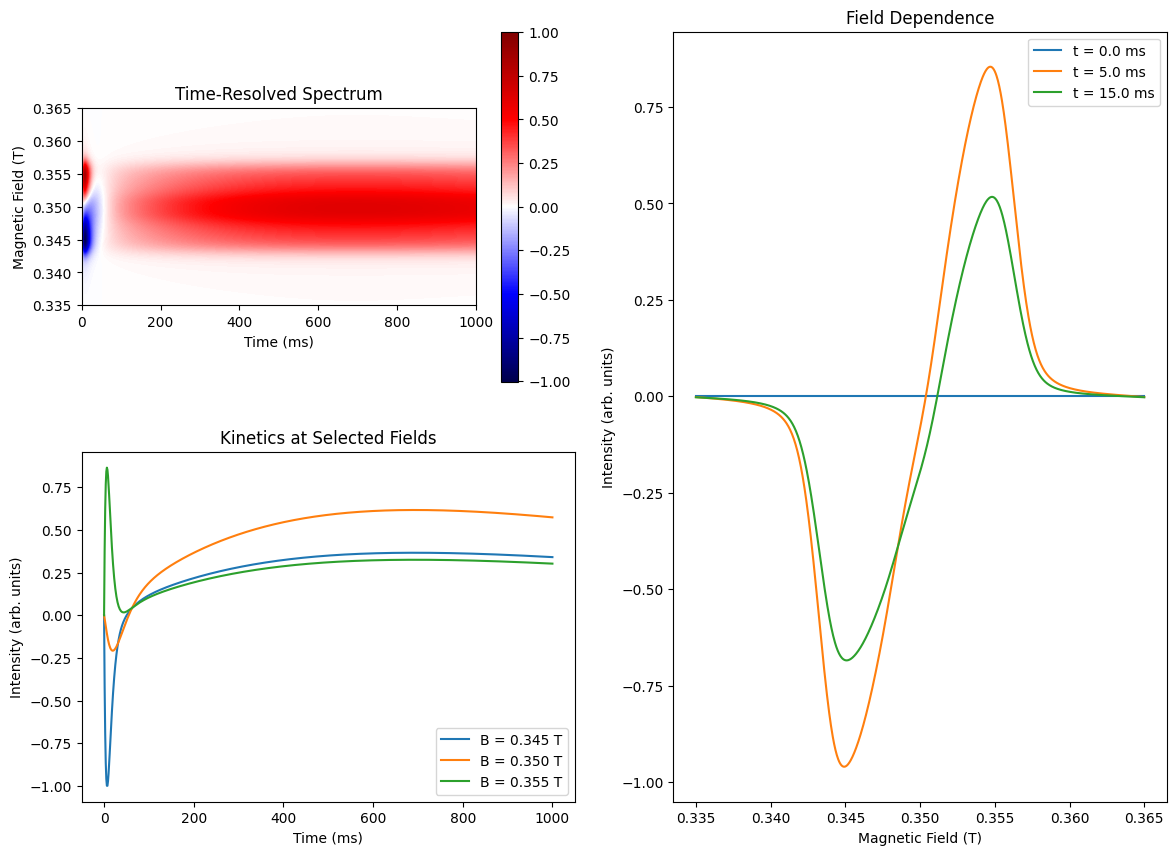

In [29]:
fields_np = fields.cpu().numpy()
time_np   = time.cpu().numpy()
time_np = time_np * 1e3 # to ms
spectrum_np = spectrum.cpu().numpy()
spectrum_np = spectrum_np / np.max(np.abs(spectrum_np))

time_points = [0.0, 5.0, 15.0]  # times (ms) to plot field-dependant spectra at the given time
field_points = [0.345, 0.35, 0.355]  # fields to plot kynetics at the given times

# --- Create mosaic layout: heat map + kinetics on left, field dependence on right ---
fig, axes = plt.subplot_mosaic([['one', 'three'],
                                ['two', 'three']], figsize=(14, 10))

# 1.
plt.sca(axes["one"])
plot_heat_map(fields_np, time_np, spectrum_np)
plt.xlabel("Time (ms)")
plt.ylabel("Magnetic Field (T)")
plt.title("Time-Resolved Spectrum")

# 2. Kinetic traces (bottom-left)
plt.sca(axes["two"])
for b_val in field_points:
    plot_kynetic(b_val, fields_np, time_np, spectrum_np.T)
plt.xlabel("Time (ms)")
plt.ylabel("Intensity (arb. units)")
plt.title("Kinetics at Selected Fields")
plt.legend([f"B = {b:.3f} T" for b in field_points])

# 3. Field-dependent spectra (right)
plt.sca(axes["three"])
for t_val in time_points:
    plot_fielddep(t_val, fields_np, time_np, spectrum_np.T)
plt.xlabel("Magnetic Field (T)")
plt.ylabel("Intensity (arb. units)")
plt.title("Field Dependence")
plt.legend([f"t = {t:.1f} ms" for t in time_points])

plt.show()